In [3]:
# Sensitivity Analysis
import pandas as pd
from mesa.batchrunner import batch_run
from solara import display
import seaborn as sns
from Model import EvacuationDec
import matplotlib.pyplot as plt
import glob
import os

# Scenario run
This notebook is used to run the scenario analysis. The cell below contains the different values for each experiments.

In [4]:

# Define the names of the variables we want to change
variabless = ['comm_watch_value_risk',
              'comm_warning_value_risk',
              'comm_watch_value_imm' ,
              'comm_warning_value_imm',
              'coeff_risk_perception']

# Define different values for the variables
base = {"outcome_collection":["SingleRun"], "ceiling": 0.4,"grow_factor":30,"media_weight_trust":0.04 ,"media_weight_perc":0.2,"phase_change_factor":0.1}
low_action_tendency = {"outcome_collection":["SingleRun"], "ceiling": 0.2,"grow_factor":60,"media_weight_trust":0.04 ,"media_weight_perc":0.2,"phase_change_factor":0.1}
media_distrust = {"outcome_collection":["SingleRun"], "ceiling": 0.4,"grow_factor":30,"media_weight_trust":0.02  ,"media_weight_perc":0.1,"phase_change_factor":0.1}
low_phase_communication = {"outcome_collection":["SingleRun"], "ceiling": 0.4,"grow_factor":30,"media_weight_trust":0.04 ,"media_weight_perc":0.2,"phase_change_factor":0.05}
RA = {"outcome_collection":["SingleRun"],"RA_base":0.75, "ceiling": 0.4,"grow_factor":30,"media_weight_trust":0.04 ,"media_weight_perc":0.2,"phase_change_factor":0.1}
para_list = [base,low_action_tendency,media_distrust,low_phase_communication,RA]

This function performs a scenario analysis using the experiments above. For each experiment provided, it runs multiple simulation iterations of the `EvacuationDec` model using the `batch_run` function. The results are collected in a DataFrame and saved as a CSV file, allowing for later analysis of how changes in parameters influence outcomes. This approach helps to identify which parameters have the most significant effects on model results.

<span style="color:red"> The results are saved, so the cell can be skipped if rerunning the analysis is not required.  </span>.

In [2]:
def sensitivity_analysis(index,parameter):
    print(f"Run for {parameter}")
    # We want to do a sensitivity analysis for all variables in the parameter_list
    # Run the batchrunner for the variable

    # for value in parameter[key]:
    result_batch = batch_run(
    EvacuationDec,
    parameters=parameter,
    iterations=150,
    max_steps=89,
    number_processes= 12,
    data_collection_period=1,
    display_progress=True,
    )
    df_sensitivity = pd.DataFrame(result_batch)
    df_sensitivity.to_csv(f"archives/scenario_runs/{index}.csv")
    del result_batch, df_sensitivity

for index,parameter in enumerate(para_list) :
    results = sensitivity_analysis(index,parameter)

Loads the saved data

In [5]:
# Path to the folder containing the CSVs
csv_folder = "archives/scenario_runs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
df_list = []
# Read and concatenate CSV files
[df_list.append(pd.read_csv(f)) for f in csv_files]



[None, None, None, None, None]

## Average evacuation decision time - Numbers
Cell gives the average evacuation decision time per scenario

In [6]:
for test in df_list:
    test_1 = test[test["Step"].max()==test["Step"]]
    print(round(test_1["average_evac_time"].mean(),2))

53.57
59.47
60.45
60.22
60.8


## Number of actively staying agents - line with 95% confidence interval
The code generates a line plot comparing multiple simulation scenarios of evacuation behavior. For each scenario, it plots the number of individuals actively choosing to stay at each time step. Different scenarios—such as changes in action tendency, media trust, communication phases, or risk assessment—are depicted with different colors and labeled accordingly.

Text(0.5, 1.0, 'Number of actively staying individuals')

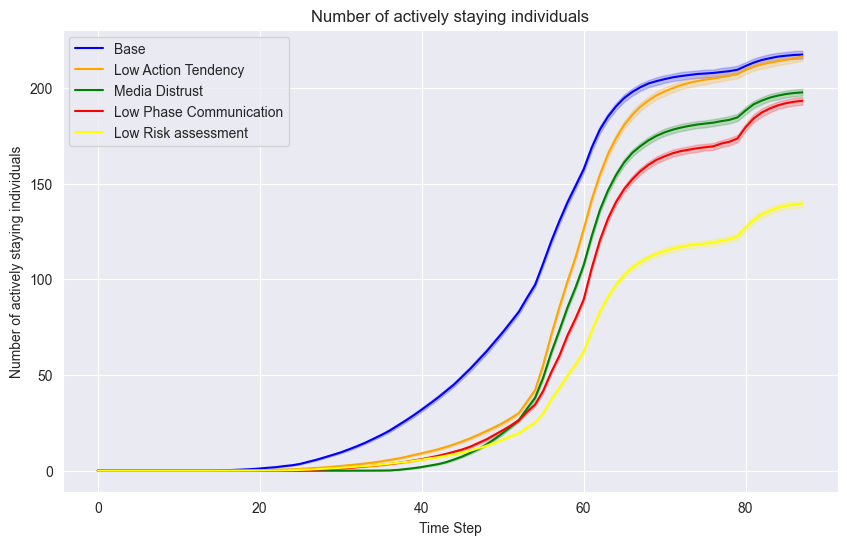

In [7]:
plt.figure(figsize=(10, 6))
scenario_names = ["Base", "Low Action Tendency", "Media Distrust", "Low Phase Communication", "Low Risk assessment"]
colors = ["blue", "orange", "green", "red", "yellow", "purple"]
for index, df_test in enumerate(df_list[:]):
    sns.lineplot(x=df_test["Step"], y=df_test["stay_choice"], color=colors[index], label=scenario_names[index])
plt.xlabel("Time Step")
plt.ylabel("Number of actively staying individuals")
plt.title("Number of actively staying individuals")

## Phase change - line
The code produces a set of three subplots to visualize how agents in the model are distributed across the Risk Identification, Risk Assessment, and Protective Action Assessment phase over time and across different scenarios. Each subplot tracks the average proportion of agents in the corresponding phase at each time step for various scenario configurations.

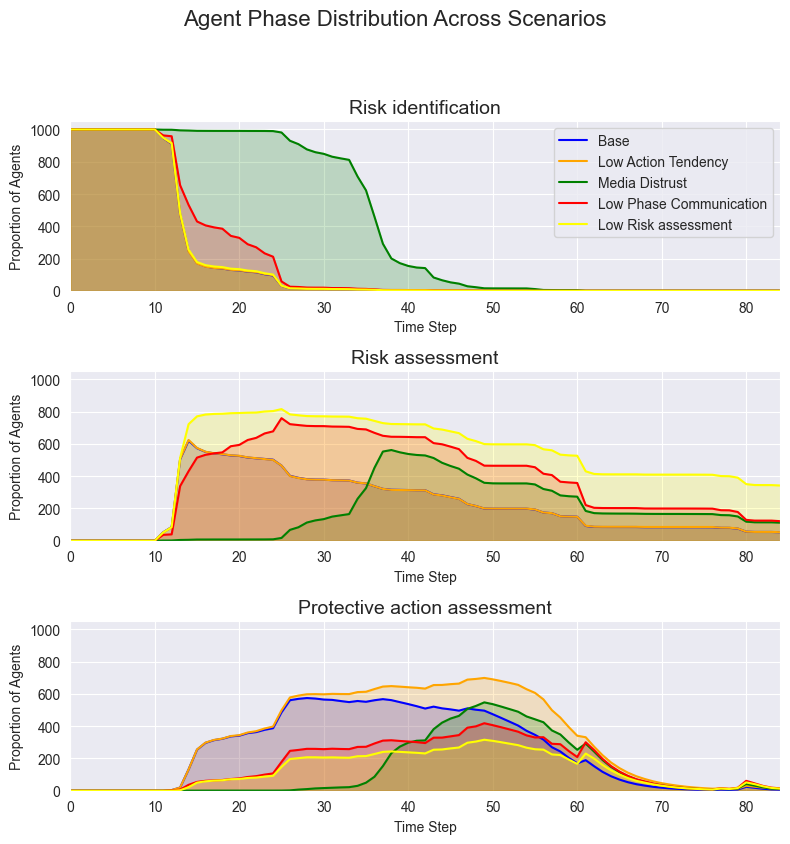

In [4]:
scenario_names = ["Base", "Low Action Tendency", "Media Distrust", "Low Phase Communication","Low Risk assessment"]
phase_names = ["Risk identification", "Risk assessment", "Protective action assessment"]
colors = ["blue","orange","green","red","yellow","purple"]

fig, ax = plt.subplots(3, 1, figsize=(8, 8))
ax = ax.flatten()

for index, df_test in enumerate(df_list[:]):
    df_test = df_test[["phase_0", "phase_1", "phase_2", "Step"]].groupby(by="Step").mean()
    for index0, column in enumerate(["phase_0", "phase_1", "phase_2"]):
        ax[index0].set_ylim(0, 1050)
        ax[index0].set_xlim(0, 84)
        line = sns.lineplot(x=df_test.index, y=df_test[column], ax=ax[index0],
                            color=colors[index], label=scenario_names[index])
        ax[index0].fill_between(df_test.index, df_test[column], color=colors[index], alpha=0.2)
        ax[index0].set_title(phase_names[index0], fontsize=14)
        ax[index0].set_xlabel('Time Step')
        ax[index0].set_ylabel('Proportion of Agents')
        if index0 == 0:  # Only add legend to first subplot
            ax[index0].legend( loc='upper right')
        else:
            ax[index0].legend().remove()  # Remove legend from other subplots

plt.suptitle('Agent Phase Distribution Across Scenarios', fontsize=16, y=1.05)
plt.tight_layout() 


## Evacuation timings - KDE-plot
The code creates a KDE-plot to visualize the distribution of evacuation decision timings for agents under different simulation scenarios. Each scenario is represented by a distinct color, showing when agents decide to evacuate throughout the simulation. The x-axis displays model time steps, as well as a secondary axis that translates time steps into actual dates for better real-world interpretation.

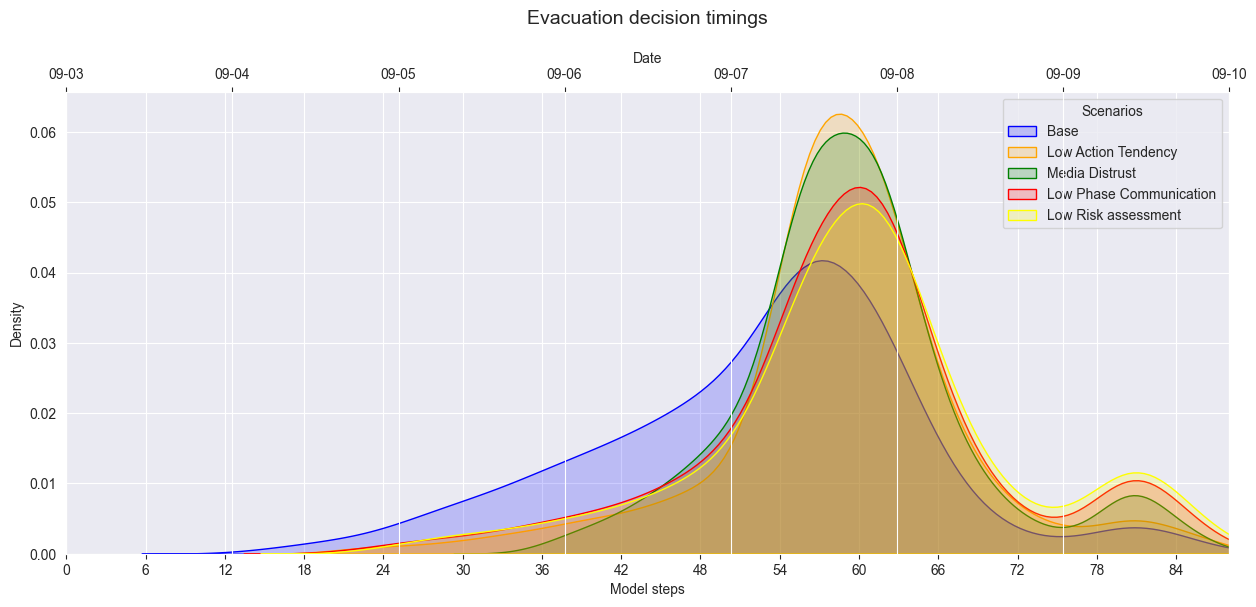

In [26]:
from datetime import datetime, timedelta
fig, ax1 = plt.subplots(figsize=(15, 6))

# Create a twin axis
ax2 = ax1.twiny()
colors = ["blue", "orange", "green", "red", "yellow","purple"]
scenario_names = ["Base", "Low Action Tendency", "Media Distrust", "Low Phase Communication","Low Risk assessment"]
for index,df in enumerate(df_list) :

    df_evac_grouped = df[["RunId", "iteration", "Step", "evac_agents"]].groupby(by=["Step"]).mean()
    evac_list = []
    for index1, value in enumerate(df_evac_grouped["evac_agents"]):
        for _ in range(round(value)):
            evac_list.append(index1)

    sns.kdeplot(data=evac_list, color=colors[index], fill=True, alpha=0.2, ax=ax1, label=scenario_names[index])

# Set up second x-axis with dates
start_date = datetime(2017, 9, 3)


def step_to_date(step):
    return start_date + timedelta(hours=2 * step)


ax1.set_xlabel("Model steps")
ax1.set_xlim(0, 88)

# Configure secondary x-axis
ax2.set_xlim(0, 84)
dates = [step_to_date(step) for step in range(0, 85, 12)]  # Increased frequency
ax2.set_xticks(range(0, 85, 12))
ax2.set_xticklabels([d.strftime('%m-%d') for d in dates], rotation=0)
ax2.set_xlabel("Date")

# Set more frequent ticks for primary axis
ax1.set_xticks(range(0, 85, 6))

plt.title("Evacuation decision timings", fontsize=14, pad=20)
ax1.legend(title="Scenarios", loc='upper right')

plt.show()

## Number of agents actively staying or being indecsive - Bar
This code creates a stacked bar chart comparing agent distributions at the final simulation time step across different scenarios. For each scenario, the chart visualizes two groups: indecisive agents (those yet to make an evacuation decision) and agents actively choosing to stay. Different colors and hatch patterns are used to distinguish these groups. This visualization highlights how scenario factors influence both decisiveness and the proportion of agents opting to remain.

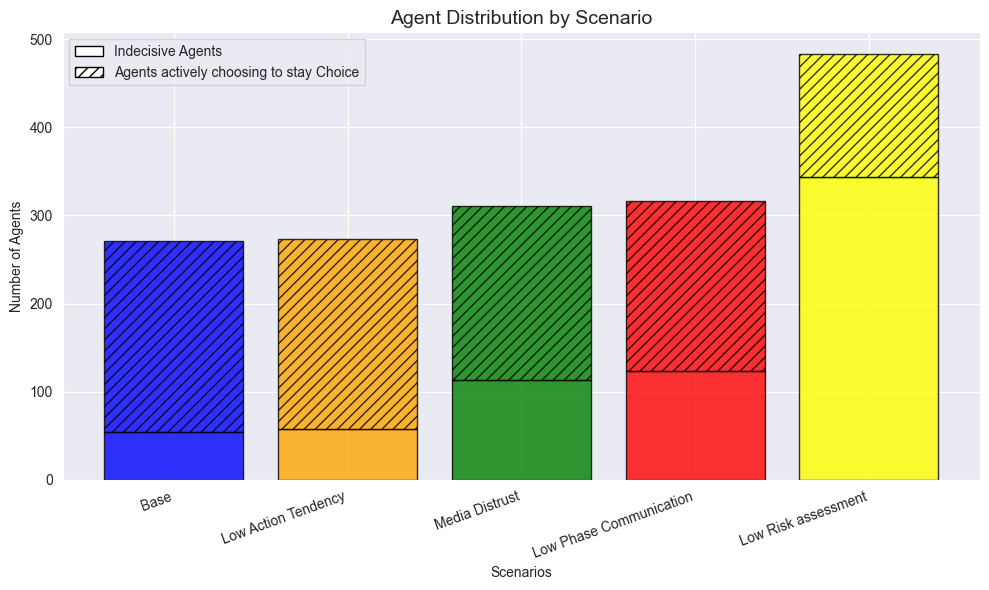

In [25]:
df_test = df_list[0]

scenario_names = ["Base", "Low Action Tendency", "Media Distrust", "Low Phase Communication","Low Risk assessment"]
phase_names = ["Risk identification", "Risk assessment", "Protective action assessment"]
colors = ["blue","orange","green","red","yellow"]
colors_saturated = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#bcbd22"]  # More vibrant colors
Nodec_list = []
env_values_list = []

fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel("Scenarios")
plt.ylabel("Number of Agents")
plt.title("Agent Distribution by Scenario", fontsize=14)
plt.xticks(rotation=20, ha='right')

for df_in in df_list:
    env_values = df_in[df_in['Step'] == df_in['Step'].max()]["stay_choice"].mean()
    last_step = df_in[df_in["Step"] == df_in["Step"].max()]
    last = last_step[["phase_0", "phase_1", "phase_2"]].sum().sum() / 150

    Nodec_list.append(last)
    env_values_list.append(env_values)

bottom_bars = plt.bar(scenario_names, Nodec_list, color=colors, alpha=0.8, label='Indecisive Agents',edgecolor='black')
top_bars = plt.bar(scenario_names, env_values_list, bottom=Nodec_list, color=colors, alpha=0.8,
                   label='Agents actively choosing to stay Choice', hatch='///',edgecolor='black')

# Create legend patches with white color but keeping the hatch patterns
legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Indecisive Agents'),
                   plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch='///',
                                 label='Agents actively choosing to stay Choice')]

plt.legend(handles=legend_elements, loc='upper left',
           fancybox=False, shadow=False, ncol=1)
plt.tight_layout()